# 概要
自然言語処理を試してみる。
データセットは https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection からダウンロードした。

In [1]:
%matplotlib inline

import nltk
import pandas as pd
import seaborn as sns
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

sns.set(style='whitegrid')

In [2]:
df = pd.read_csv('../data/SMSSpamCollection', sep='\t', names=['label', 'message'])
df['length'] = df.message.apply(len)
df['word_count'] = df.message.apply(lambda x: len(x.split()))
df.head()

,label,message,length,word_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28
3,ham,U dun say so early hor... U c already then say...,49,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13


/Users/ken/.pyenv/versions/3.6.0/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


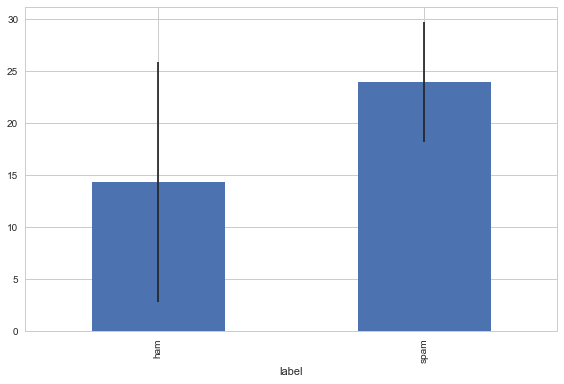

In [3]:
grouped = df.groupby('label').word_count
grouped.mean().plot.bar(yerr=grouped.std())

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10f8e1cf8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11669e588>], dtype=object)

/Users/ken/.pyenv/versions/3.6.0/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


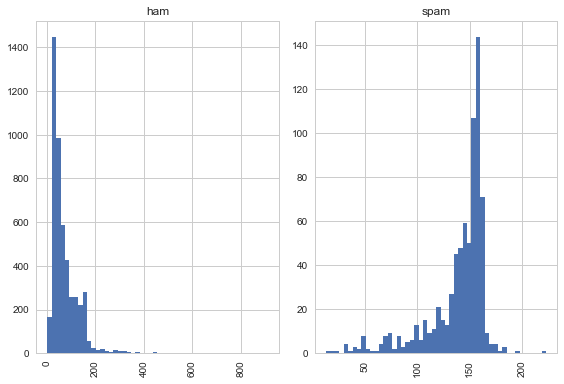

In [4]:
df.hist(column='length', by='label', bins=50)

文章を単語ごとに分割したり、stop wordなど余計な単語を除いたりする処理をする関数を用意する。
返り値は、単語の配列にする。

ここではstring.punctuationに含まれる記号などを文章から取り除く関数を用意した。

In [5]:
def text_process(t):
    return ''.join([c for c in t if c not in string.punctuation]).split()

試しに文章を単語に分割してみる。

In [6]:
text_process(df.ix[0].message)

['Go',
 'until',
 'jurong',
 'point',
 'crazy',
 'Available',
 'only',
 'in',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 'Cine',
 'there',
 'got',
 'amore',
 'wat']

文章ベクトルを作成するためにはCoutVectorizerを利用する。

In [7]:
transformer = CountVectorizer(analyzer=text_process)

In [8]:
transformer.fit(df.message)

CountVectorizer(analyzer=<function text_process at 0x1168f0d90>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
        stop_words=None, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)

transform関数で単語数が文章にいくつ含まれるかの疎行列を作成してくれる。

ここでは、1つの文章を与えた場合の例を示す。

In [9]:
transformer.transform([df.message[0]])

<1x11747 sparse matrix of type '<class 'numpy.int64'>'
	with 20 stored elements in Compressed Sparse Row format>

疎行列はそのままではわかりにくいのでprintしてみる。

単語それぞれに列番号(1133, 1521, 2113など)がふられている。
左にある(0, 1133)などは値が入っている行列の成分、左はその単語の個数。

In [10]:
print(transformer.transform([df.message[0]]))

  (0, 1133)	1
  (0, 1521)	1
  (0, 2113)	1
  (0, 4853)	1
  (0, 5430)	1
  (0, 5431)	1
  (0, 5985)	1
  (0, 6441)	1
  (0, 7135)	1
  (0, 7166)	1
  (0, 7574)	1
  (0, 7805)	1
  (0, 7919)	1
  (0, 8595)	1
  (0, 8863)	1
  (0, 9192)	1
  (0, 10708)	1
  (0, 11060)	1
  (0, 11269)	1
  (0, 11480)	1


列番号に対応する単語はget_feature_namesで抽出できる。

In [11]:
transformer.get_feature_names()[1133]

'Available'

全ての文章を単語行列に変換する。

In [12]:
bow_matrix = transformer.transform(df.message)

どのくらいゼロじゃない値が入っているか、nnz関数で抽出できる。

ここでは、どのくらい疎であるかを計算。
shape[0]が文章数。shape[1]が単語数。

In [13]:
bow_matrix.nnz/(bow_matrix.shape[0] * bow_matrix.shape[1])

0.0012140229049026035

# tf-idf
ここでは、tfidfをかけてみる。

In [14]:
tfidf = TfidfTransformer().fit(bow_matrix)

試しに1つの文章にtfidfをかけてみる。

In [15]:
print(tfidf.transform(transformer.transform([df.message[0]])))

  (0, 11480)	0.218555049639
  (0, 11269)	0.181033180208
  (0, 11060)	0.210209106925
  (0, 10708)	0.150501903483
  (0, 9192)	0.234481271951
  (0, 8863)	0.149301441456
  (0, 8595)	0.161798333911
  (0, 7919)	0.250604581884
  (0, 7805)	0.296642262259
  (0, 7574)	0.100036124244
  (0, 7166)	0.174137649953
  (0, 7135)	0.143874860734
  (0, 6441)	0.179534768156
  (0, 5985)	0.237139423564
  (0, 5431)	0.255039048146
  (0, 5430)	0.283177103939
  (0, 4853)	0.296642262259
  (0, 2113)	0.229729012196
  (0, 1521)	0.296642262259
  (0, 1133)	0.273623422071
